# Abstract
Intrigued by the overwhelming popularity of Deep Learning and the pace at which it is prevailing, we wanted to broaden our horizons in  this direction as well. There has been amazing work since its origin which spawned many different models for deep learning such as- 

VGG16

VGG19

Residual Network

CNN

This notebook illustrates the implementation of Convolution Neural Network.
#### CNNs- Convolutional Neural Network 
CNNsare regularized versions of multilayer perceptrons. Multilayer perceptrons usually refer to fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks make them prone to overfitting data. Typical ways of regularization includes adding some form of magnitude measurement of weights to the loss function. However, CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, on the scale of connectedness and complexity, CNNs are on the lower extreme.

### Dataset
The dataset used is a very famous dataset called fer2013 which could be found at-
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

### Exploratory Data Analysis
The dataset consists of the pixel values of the image in 48 cross 48 matrix form along with emotions that are one hot encoded.
Here let's build images out of the pixel points and see what has to be fed into the model for training the model.

In [17]:
# Libraries to be imported
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [18]:
#GPU Configuration because image processing and convolutional neural network can process faster

config = tf.ConfigProto( device_count = {'GPU': 1} ) #Allow TensorFlow to use your GPU, GPU = 0 will only make use of the CPU
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [19]:
# Loading the csv file into pandas dataframe
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [20]:
# for displaying the last 5 rowws in the dataset
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [21]:
# Count number of samples and sample size 

with open("fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


In [22]:
#Initialize train, test and validation set

x_train, y_train, x_test, y_test, x_val, y_val = [], [], [], [], [], []

In [23]:
#Parameters to fed in the model
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256 #number of images to be trained in one go
epochs = 100 # the number of iterations for training the model

In [24]:
#Transfer data into the lists created in the previous block
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
        elif 'PrivateTest' in usage:
            y_val.append(emotion)
            x_val.append(pixels)
    except:
        print("",end="")

In [25]:
#Data transformation for train, test and validation sets

x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')
x_val = np.array(x_val, 'float32')
y_val = np.array(y_val, 'float32')

#normalize inputs between [0, 1]

x_train /= 255 
x_val /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_val = x_val.reshape(x_val.shape[0], 48, 48, 1)
x_val = x_val.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

#Count the number of samples in each set

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validaiton samples')

28709 train samples
3589 test samples
3589 validaiton samples


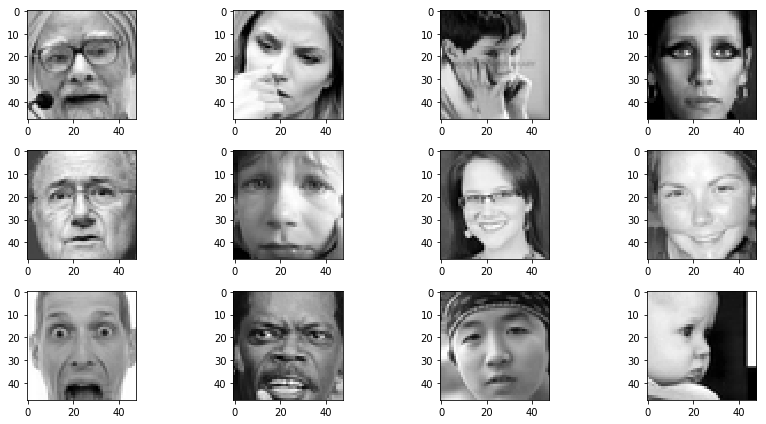

In [0]:
# Let's take a look at the images being fed to the model for training
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

# Building the CNN model
The CNN model we have built has 3 convolutional layers. 
#### Batch normalization 
is used to normalise the activations of previous layers at each batch,
this applies transformation that maintains the mean activation close to 0 and the standard deviation close to 1.
#### Max Pooling 
is placed between the convolutional layers and it helps in reducing the dimensionality of the images by reducing the 
number of pixels in the output from previous convolutional layer.
#### Flatten
Flattening a tensor means to remove all of the dimensions except for one.
#### Dense
Here, we have specified the dense to have a hidden layer with 1024 neurons
#### Activation Functions
ReLu(Rectified Linear Unit) and softmax are the two activations we have used in the CNN.

In [26]:
#Building the network

model = Sequential()

#1st Convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
#64 refers to the number of channels and each channel having 5 cross 5 matrix with the activation function as reLu
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

#2nd Convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

#3rd Convolution layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#Fully Connected Layers

model.add(Dense(1024))#, activation='relu')) # This means that the hidden layer has 1024 neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1024))#, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 64)        102464    
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
__________

In [0]:
#Data Augmentation and Batch Process
#Keras provides the ImageDataGenerator class that defines the configuration for image 
# data preparation and augmentation. This includes capabilities such as:

# Sample-wise standardization.
# Feature-wise standardization.
# ZCA whitening.
# Random rotation, shifts, shear and flips.
# Dimension reordering.
# Save augmented images to disk.

gen = ImageDataGenerator(
      rotation_range = 45,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip=True,
      fill_mode = 'nearest')


train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [27]:
#The compilation step
# Categorical Cross Entropy loss-
# Also called Softmax Loss. 
# It is a Softmax activation plus a Cross-Entropy loss. 
# If we use this loss, we will train a CNN to output a probability over the C classes for each image. 
# It is used for multi-class classification. Thus, the resultant

# And the optimizer we have used is Adam optimizer

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam(lr = 0.0001)
    , metrics=['accuracy'])

In [0]:
#Fit the model in 100 epochs with a batch size of 256

history = model.fit_generator(train_generator, 
                              validation_data = (x_val, y_val), 
                              steps_per_epoch=batch_size, 
                              epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
256/256 [==============================] - 33s 129ms/step - loss: 2.0678 - acc: 0.2150 - val_loss: 1.8898 - val_acc: 0.2466
Epoch 2/100
256/256 [==============================] - 26s 100ms/step - loss: 1.9282 - acc: 0.2427 - val_loss: 1.8543 - val_acc: 0.2566
Epoch 3/100
256/256 [==============================] - 26s 101ms/step - loss: 1.8598 - acc: 0.2618 - val_loss: 1.7904 - val_acc: 0.2692
Epoch 4/100
256/256 [==============================] - 27s 105ms/step - loss: 1.7936 - acc: 0.2929 - val_loss: 1.6955 - val_acc: 0.3137
Epoch 5/100
256/256 [==============================] - 26s 100ms/step - loss: 1.7254 - acc: 0.3157 - val_loss: 1.5753 - val_acc: 0.3820
Epoch 6/100
256/256 [==============================] - 26s 100ms/step - loss: 1.6618 - acc: 0.3459 - val_loss: 1.5123 - val_acc: 0.4143
Epoch 7/100
256/256 [==============================] - 27s 105ms/step - loss: 1.6181 - acc: 0.3658 - val_loss: 1.4925 - val_acc: 0.4196


In [0]:
# Save the weights

model.save('fed_16.h5')

In [0]:
# Saving the CNN model

model.save('fed.tfl')

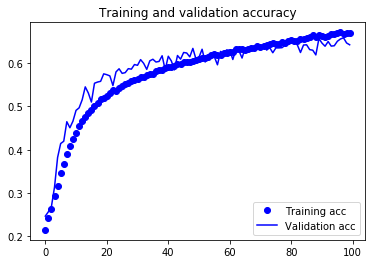

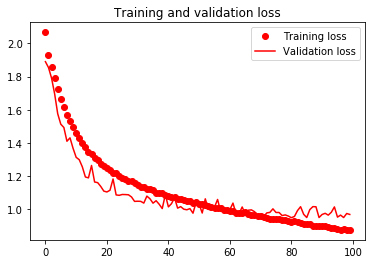

In [0]:
#Graphs for training and validation accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Graph for training and validation loss

plt.plot(epochs, loss, 'bo', color = 'red', label='Training loss')
plt.plot(epochs, val_loss, 'b', color = 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
#Evaluation on the test set

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

3589/3589 [==============================] - 1s 226us/step
Test loss: 1.005698105175537
Test accuracy: 64.14042909220422


### Therefore, the accuracy of the model is-

Training accuracy-0.6709

Testing accuracy-0.6414042909220422

In [0]:
#function for drawing bar chart for emotion preditions

def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [0]:
monitor_testset_results = False

if monitor_testset_results == True:
    #make predictions for test set
    predictions = model.predict(x_test)

    index = 0
    for i in predictions:
        if index < 30 and index >= 20:
            testing_img = np.array(x_test[index], 'float32')
            testing_img = testing_img.reshape([48, 48]);
            
            plt.gray()
            plt.imshow(testing_img)
            plt.show()
            
            print(i)
            
            emotion_analysis(i)
            print("----------------------------------------------")
        index = index + 1

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


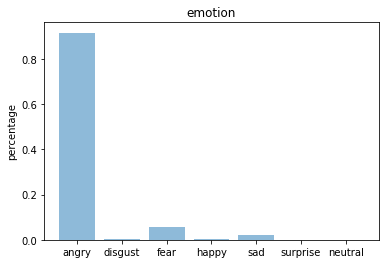

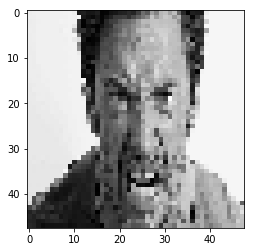

In [0]:
# make prediction for image chosen out of the data available
# while doing it on custom images firstly we convert the images to arrays

img = image.load_img("angryface.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])


x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

Let's try this with different faces and emotions/expressions

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


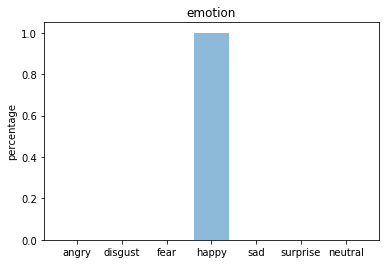

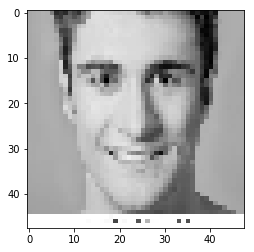

In [0]:
img = image.load_img("happy.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


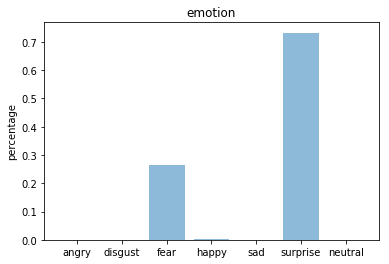

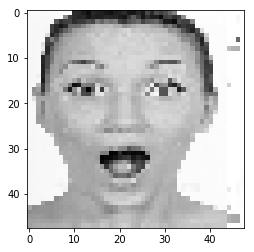

In [0]:


img = image.load_img("sur.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


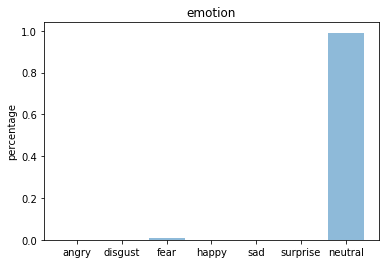

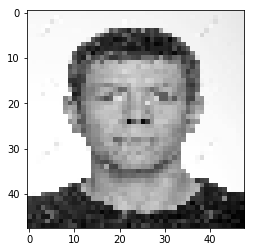

In [0]:
img = image.load_img("nn.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

In [ ]:
By far we can see that the model is almost accurate in predicting the outputs.

In [13]:
#load the weights of the model

from keras.models import load_model

model = load_model('fed_16.h5')
model.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch

###### Let's try to see what has been the inputs in between layers, that is the images being fed in between the layers after filters have been applied

In [14]:
img_path = 'angryface.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(48, 48, 1))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

print(img_tensor.shape)

(1, 48, 48, 3)


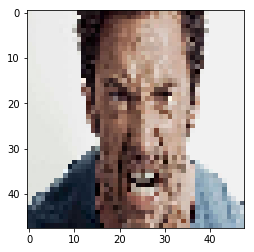

In [15]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [0]:
from keras import models

# Extracts the outputs of the top 12 layers:

layer_outputs = [layer.output for layer in model.layers[:21]]

# Creates a model that will return these outputs, given the model input:

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
# This will return a list of 5 Numpy arrays:

# one array per layer activation

activations = activation_model.predict(x_train[10].reshape(1,48,48,1))

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 44, 44, 64)


In [ ]:
Let's try to analyse the various transformations in the image after passing through the convolutional layers.

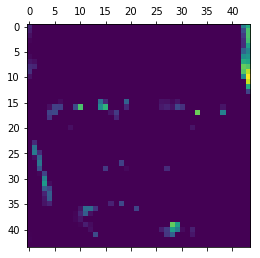

In [0]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

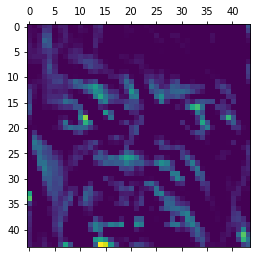

In [0]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


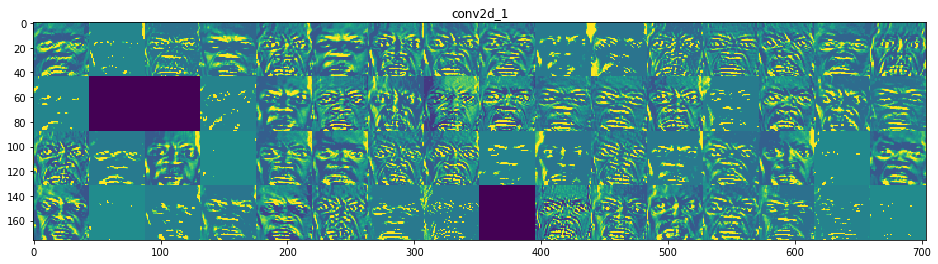

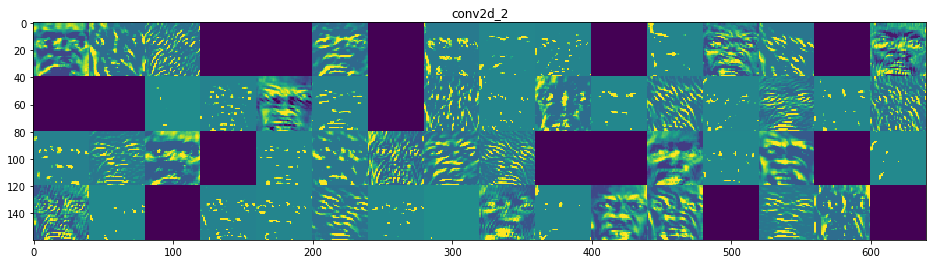

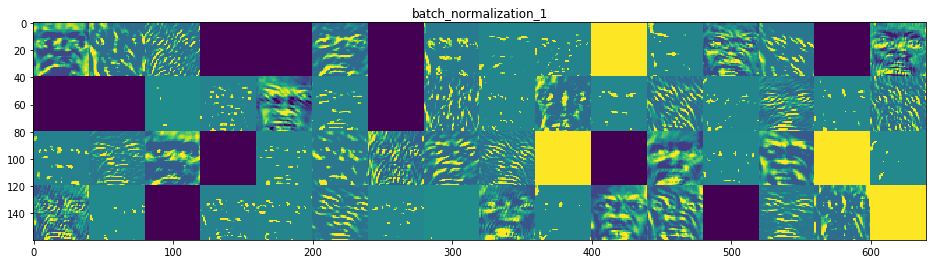

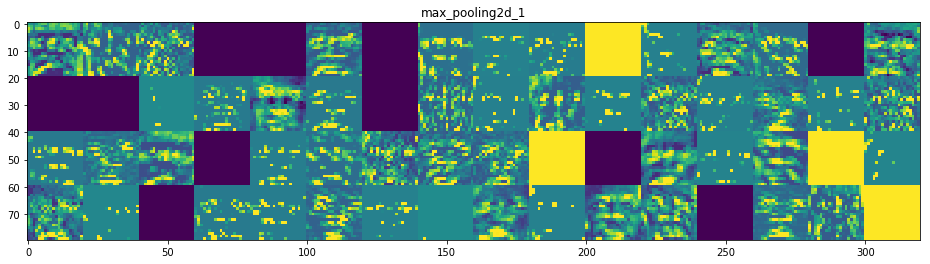

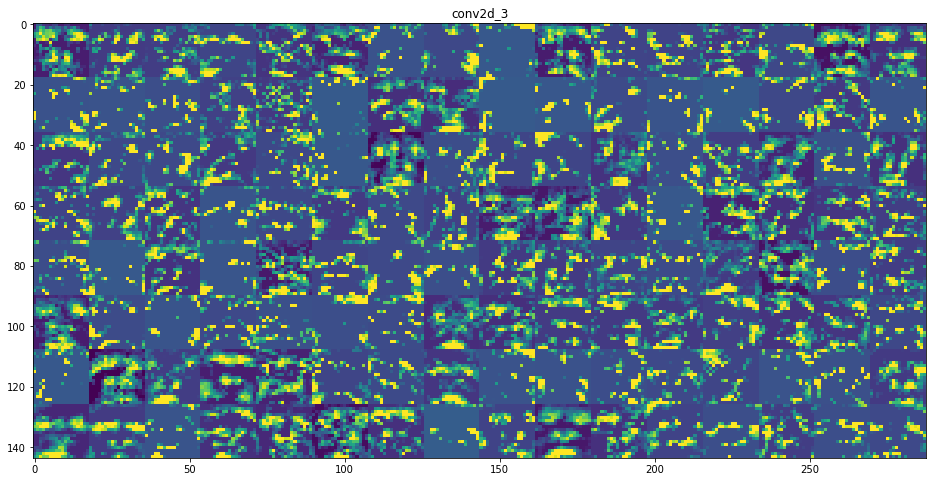

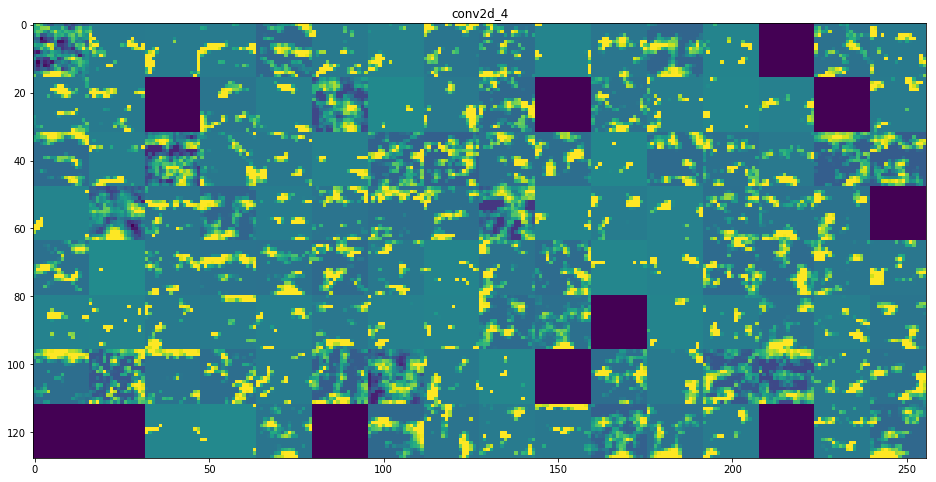

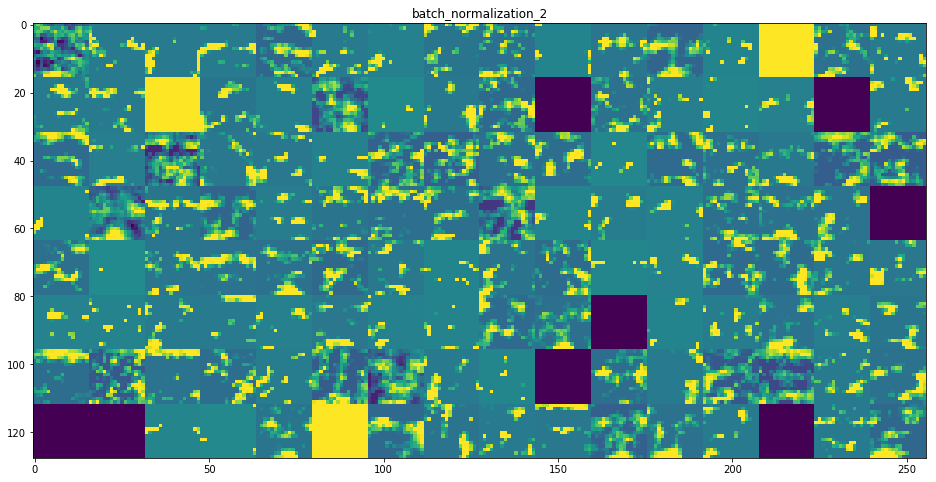

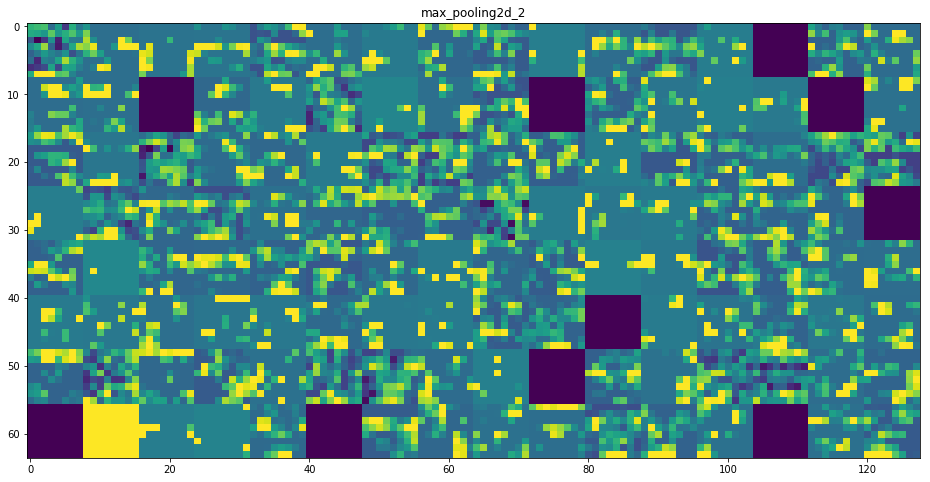

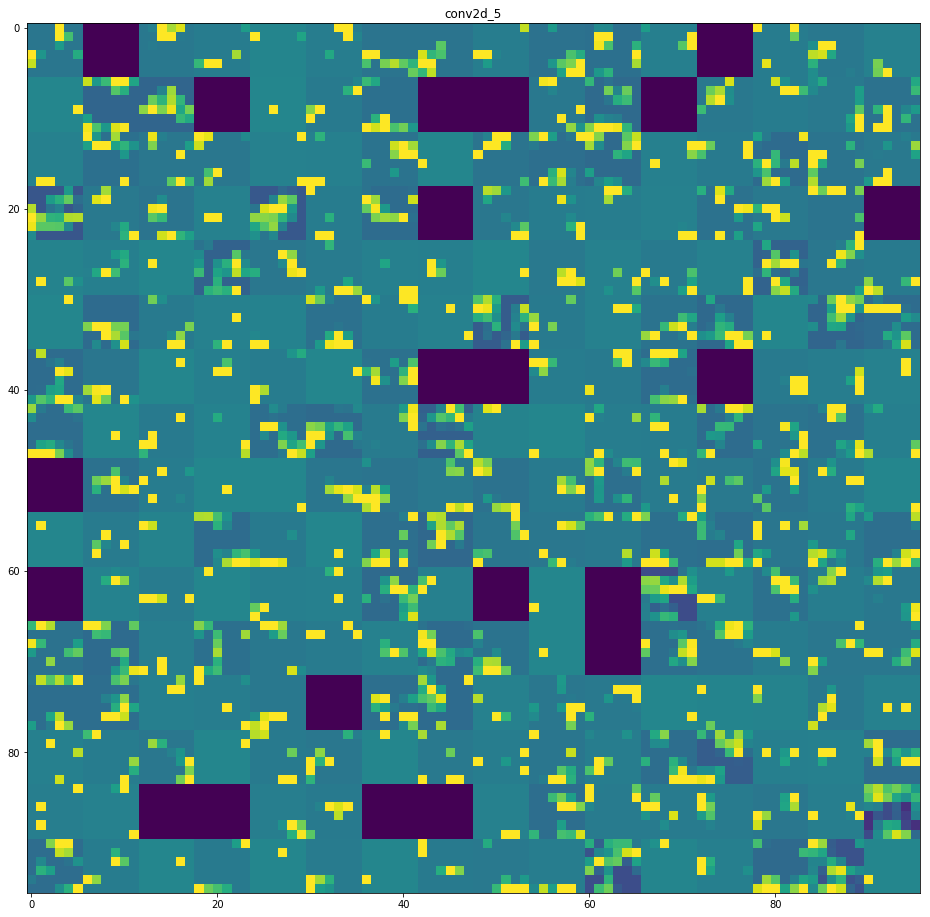

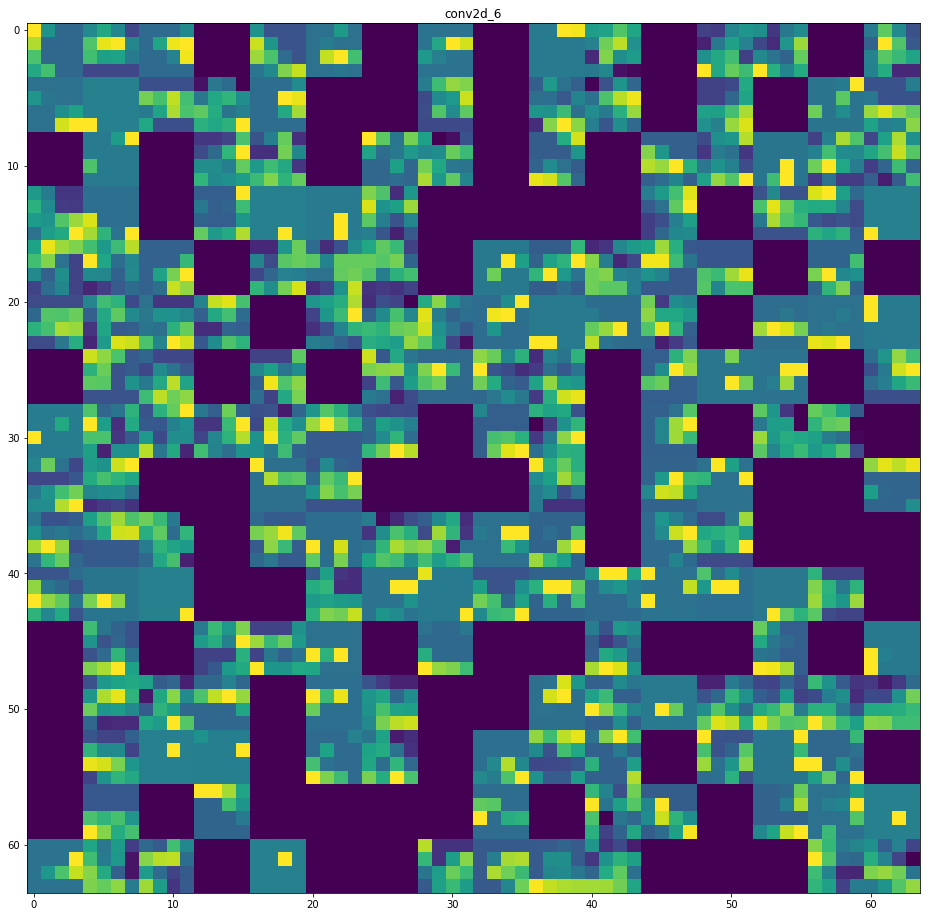

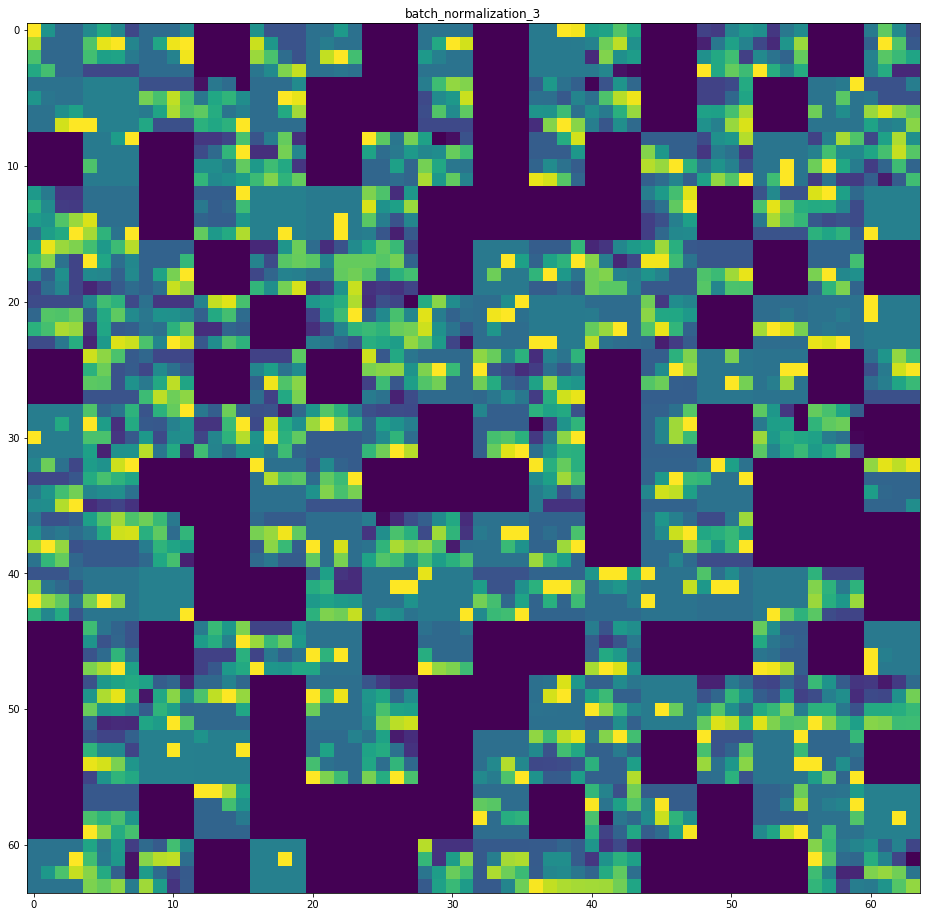

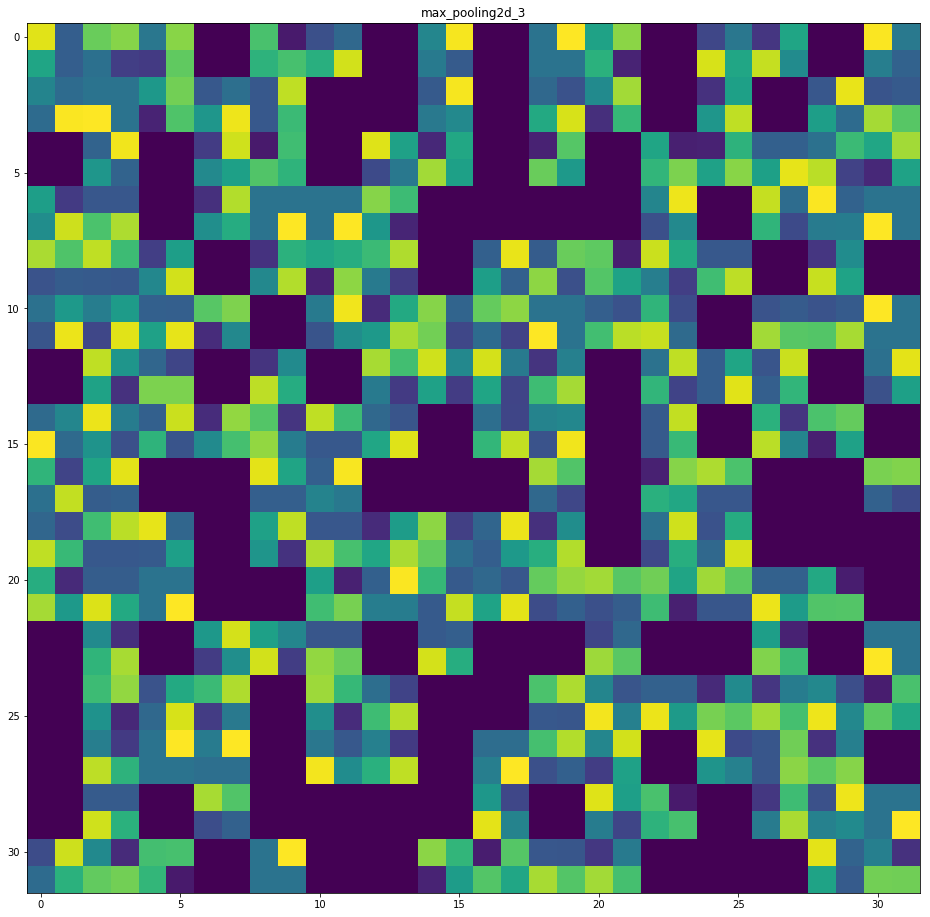

In [0]:

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

This shows the images in the different layers of the Convolutional model

In [0]:
Y_prediction = model.predict(x_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

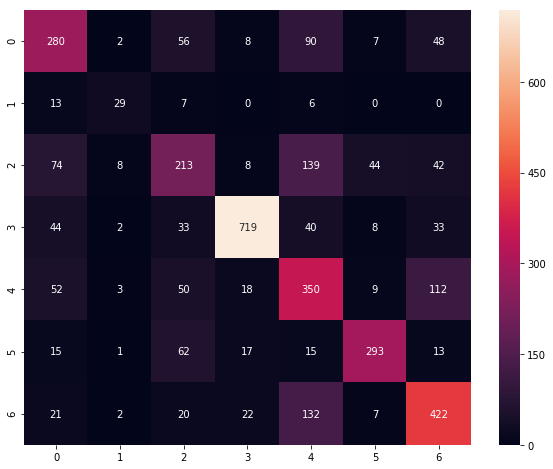

In [0]:
# Confusion matrix for the facial image recognition 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [28]:
#opencv initialization

# A Haar Cascade is basically a classifier which is used to detect particular objects from the source.
# The haarcascade_frontalface_default.xml is a haar cascade designed by OpenCV to detect the frontal face. 

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [29]:
# For Facial Expression on a video, we can specify the source to be a video
cap = cv2.VideoCapture(0)

In [30]:
#face expression recognizer initialization
# from keras.models import model_from_json
#model = model_from_json(open("facial_expression_model_structure.json", "r").read())
model.load_weights('fed_16.h5') #load weights

In [14]:
model.evaluate(x_test,y_test)

3589/3589 [==============================] - 56s 16ms/step


[1.0056955210509557, 0.6414042909220422]

In [31]:
# The following is the code for live facial expression recognition
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

while(True):
    ret, img = cap.read()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image
        
        detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
        detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
        detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        img_pixels /= 255 #pixels are in scale of [0, 255]. normalize all pixels in scale of [0, 1]
        
        predictions = model.predict(img_pixels) #store probabilities of 7 expressions
        
        #find max indexed array 0: angry, 1:disgust, 2:fear, 3:happy, 4:sad, 5:surprise, 6:neutral
        max_index = np.argmax(predictions[0])
        
        emotion = emotions[max_index]
        
        #write emotion text above rectangle
        cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
        #process on detected face end
        #-------------------------
        cv2.imshow('img',img)

    if cv2.waitKey(1) & 0xFF == ord('q'): #press q to quit
        break
        
#kill open cv things
cap.release()
cv2.destroyAllWindows()

# Conclusion
For a Convolutional Neural Network that we have build, the accuracy of the model is-

Training accuracy-0.6709

Testing accuracy-0.6414042909220422

The main aim was implementing this model in real time using web cam. we have been successful in doing this. One very important feature we have implemented is creation of windows/frames and thus, multiple faces could be recognised at a time.

# Contribution
In the above analysis:

60% of the work is done by us which includes

VGG19 and ResNet implementation
CNN accuracy improvement
Live webcam code optimization
40% of the work is taken from web

# Citations
For face detection - https://www.youtube.com/watch?v=PmZ29Vta7Vc

VGG19 using tflearn - https://www.mathworks.com/help/deeplearning/ref/vgg19.html;jsessionid=ccf9599bd865b423281a56299a68

For VGG19 and ResNet - https://github.com/tflearn/tflearn/tree/master/examples/images

For tflearn - http://tflearn.org/tutorials/

Facial Emotion Recognition using CNN - http://sefiks.com/2018/01/01/facial-expression-recognition-with-keras/



# License
MIT License

Copyright (c) 2019 Ritu Agrawal, Nikhil Kashid

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.